In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
import plotly
import matplotlib.pyplot as plt
import sys

!{sys.executable} -m pip install matplotlib2tikz

pd.set_option('display.max_rows', 1000)

# Note: updates country list to keep current sample

countries_tot = ['Austria', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia',
                 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
                 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy',
                 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'Norway',
                 'Poland', 'Portugal', 'Romania', 'Serbia', 'Slovakia', 
                 'Spain', 'Slovenia', 'Sweden', 'Switzerland', 'United Kingdom']
len(countries_tot)


30

In [2]:
df_npi = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv')

df_npi.rename(columns = {'Date':'date'}, inplace = True)

#df_npi['CountryName'] = df_npi['CountryName'].str.lower()

df_npi = df_npi.replace({'Slovak Republic' : 'Slovakia', "Czechia" : "Czech Republic" },regex=True)

df_npi.date = df_npi.date.apply(lambda x: str(x)[:4] +'-'+str(x)[4:6]+'-'+str(x)[6:8])

df_npi['RegionName'] = df_npi['RegionName'].fillna('')
df_npi = df_npi.drop(df_npi.loc[df_npi['RegionName']!=''].index)

df_npi = df_npi.drop(columns=['CountryCode', 'RegionName', 'RegionCode','Jurisdiction'])

df_npi = df_npi[df_npi['CountryName'].isin(countries_tot)]

display(df_npi['CountryName'].value_counts(sort=True))
df_npi['CountryName'].nunique()

C:\Users\ngolenvaux\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Austria                   700
Belgium                   700
Slovenia                  700
Slovakia                  700
Serbia                    700
Romania                   700
Portugal                  700
Poland                    700
Norway                    700
Netherlands               700
Latvia                    700
Luxembourg                700
Lithuania                 700
Italy                     700
Ireland                   700
Hungary                   700
Croatia                   700
Greece                    700
United Kingdom            700
France                    700
Finland                   700
Estonia                   700
Spain                     700
Denmark                   700
Germany                   700
Czech Republic            700
Switzerland               700
Bosnia and Herzegovina    700
Bulgaria                  700
Sweden                    700
Name: CountryName, dtype: int64

30

In [3]:
df_owid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

df_owid = df_owid.replace({'Slovak Republic' : 'Slovakia', "Czechia" : "Czech Republic" },regex=True)

df_owid = df_owid[df_owid['location'].isin(countries_tot)]
df_owid = df_owid[['location', 'date', 'new_cases_per_million','new_cases_smoothed_per_million',
                   'new_deaths_per_million','new_deaths_smoothed_per_million','population', 'population_density',
                   'total_cases_per_million','total_deaths_per_million','gdp_per_capita']]

df_owid['location'].nunique()

30

In [4]:
df_owid = pd.merge(df_owid, df_npi, how='left', left_on=['date','location'], 
              right_on=['date','CountryName']).drop(columns= ['CountryName']) 
df_owid = df_owid[df_owid.date >= '2020-02-29']
df_owid = df_owid[df_owid.date <= '2021-02-28']
df_owid = df_owid.fillna(0.0)

df_owid.rename(columns={"location": "CountryName"}, inplace=True)


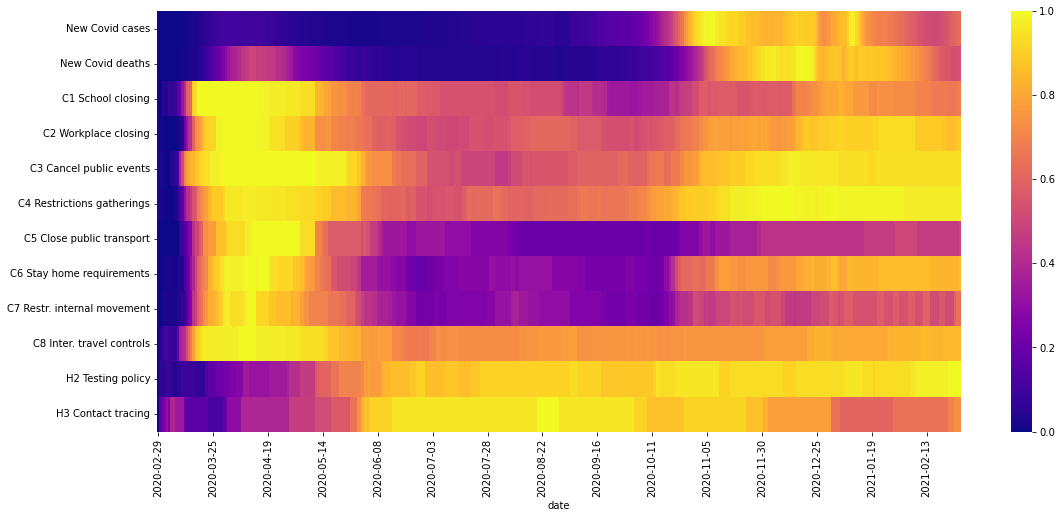

In [5]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

cols = ['new_cases_smoothed_per_million',
 'new_deaths_smoothed_per_million',
 'C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'H2_Testing policy',
 'H3_Contact tracing']

labels= ['New Covid cases',
 'New Covid deaths',
 'C1 School closing',
 'C2 Workplace closing',
 'C3 Cancel public events',
 'C4 Restrictions gatherings',
 'C5 Close public transport',
 'C6 Stay home requirements',
 'C7 Restr. internal movement',
 'C8 Inter. travel controls',
 'H2 Testing policy',
 'H3 Contact tracing']

df_owid_date = df_owid.drop(columns={'CountryName'}).groupby(['date']).mean()[cols]
df_owid_country = df_owid.drop(columns={'date'}).groupby(['CountryName']).mean()[cols]
df_owid_date = pd.DataFrame(MinMaxScaler().fit_transform(df_owid_date.values).transpose(),index=df_owid_date.columns,columns=df_owid_date.index)
df_owid_country = pd.DataFrame(MinMaxScaler().fit_transform(df_owid_country.values).transpose(),index=df_owid_country.columns,columns=df_owid_country.index)
plt.figure(figsize=(18,8))
plt.gcf().subplots_adjust(bottom=0.15)


ax = sns.heatmap(df_owid_date,cmap='plasma',xticklabels=25)
ax.set_yticklabels(labels)
plt.savefig('../output/NPIs.pdf'); 


In [6]:
df_owid['new_cases_smoothed_per_million'] = df_owid['new_cases_smoothed_per_million'].transform(lambda x: (x - x.min())/ (x.max() - x.min()))
df_owid['new_deaths_smoothed_per_million'] = df_owid['new_deaths_smoothed_per_million'].transform(lambda x: (x - x.min())/ (x.max() - x.min()))


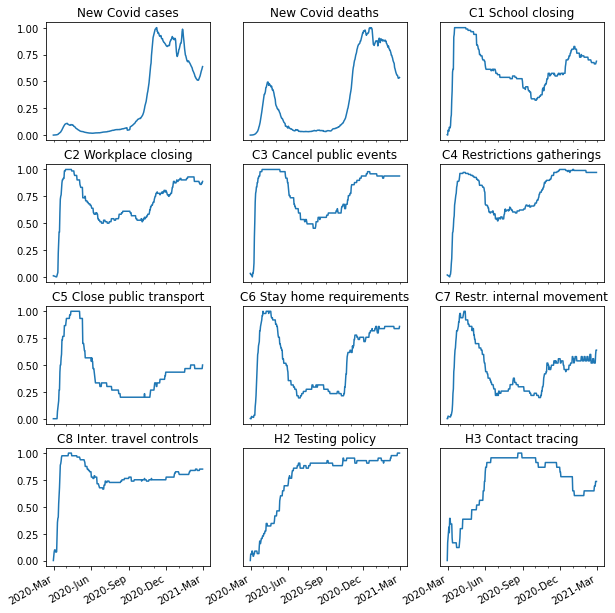

<Figure size 432x288 with 0 Axes>

In [42]:
import matplotlib.dates as mdates
from datetime import datetime
fig, axes = plt.subplots(nrows=4,ncols=3,figsize=(10,10))
dates = [datetime.fromisoformat(date) for date in df_owid_date.columns]
for i, name in enumerate(df_owid_date.index):
    axes[int(i/3),i%3].plot(dates,list(df_owid_date.loc[name,:]))
    axes[int(i/3),i%3].set_title(labels[i])
    axes[int(i/3),i%3].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3,6,9,12)))
    axes[int(i/3),i%3].xaxis.set_minor_locator(mdates.MonthLocator())
    axes[int(i/3),i%3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    # Rotates and right-aligns the x labels so they don't crowd each other.
    for label in axes[int(i/3),i%3].get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    if i % 3 != 0:
        axes[int(i/3),i%3].set_yticks([])
    if i < 9:
        axes[int(i/3),i%3].set_xticks([])
plt.show()
plt.savefig('../output/NPIs_plot.pdf');